In [1]:
import pickle
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from optuna.samplers import RandomSampler
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
max_n_jobs = multiprocessing.cpu_count()
print(f"Maximum n_jobs you can use: {max_n_jobs}")
import shap

/Users/justpqa/drw-crypto-market-prediction/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Maximum n_jobs you can use: 12


In [2]:
feature_version = 2
# 1 for pc feature, 
# 2 for label correlation feature # seems to work most consistently
# 3 for best features based on combination rank

In [3]:
default_random_state = 101

#### Import train data and popular features

In [4]:
train_df = pd.read_parquet(f"data/cleaned/cleaned_train_{feature_version}.parquet")
train_df.head()

,X473,X205,X198,X444,X466,X445,X472,X26,X29,X217,...,normalized_buy_volume,normalized_sell_volume,liquidity_adjusted_imbalance,pressure_spread_interaction,trade_direction_ratio,net_buy_volume,bid_skew,ask_skew,timestamp,label
0,-0.201346,-1.978504,-1.700689,-0.142546,-0.163476,-0.128331,-0.126241,1.406392,1.474789,-0.981975,...,11.542564,5.339347,0.063569,-0.230493,0.796810,131.421,0.644635,0.355365,2023-03-01 00:00:00,0.562539
1,-0.186231,-1.830295,-1.669471,-0.135499,-0.159388,-0.124790,-0.115015,1.003783,1.312735,-0.940190,...,13.626484,137.821061,0.011610,-0.549445,0.620251,203.896,0.942921,0.057079,2023-03-01 00:01:00,0.533686
2,-0.182398,-1.803540,-1.662645,-0.133705,-0.158627,-0.123891,-0.112303,0.760801,1.219124,-0.933071,...,360.242073,2.263386,0.015877,0.530818,0.538664,22.858,0.007283,0.992717,2023-03-01 00:02:00,0.546505
3,-0.177415,-1.714013,-1.620037,-0.133251,-0.158334,-0.123658,-0.109113,0.955549,1.353001,-0.891216,...,69.011716,5.946089,0.025702,0.454780,0.728757,210.779,0.187976,0.812024,2023-03-01 00:03:00,0.357703
4,-0.174164,-1.684170,-1.600188,-0.128862,-0.156668,-0.121464,-0.106383,0.905460,1.361880,-0.878711,...,3.623647,12.867864,0.081042,-0.533689,0.689066,54.004,0.887255,0.112745,2023-03-01 00:04:00,0.362452


In [5]:
popular_features_train = pd.read_parquet("data/cleaned/popular_features_train.parquet")
popular_features_train.head()

,volume,bid_qty,ask_qty,buy_qty,sell_qty
0,221.389,15.283,8.425,176.405,44.984
1,847.796,38.590,2.336,525.846,321.950
2,295.596,0.442,60.250,159.227,136.369
3,460.705,4.865,21.016,335.742,124.963
4,142.818,27.158,3.451,98.411,44.407


#### Implement some helper function

In [6]:
# First need to split into some fold
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])

default_cv = 1
# NOTE: default_cv must set to 1 instead of 3 based on consistency with LB score contains 49% of test data
# NOTE: 3 cv with gap is slightly better or almost equal

def create_cv(train_df, features=None, cv=default_cv):
    if features is not None:
        train_df = train_df[features + ["timestamp", "label"]]
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    for i in range(cv):
        # train_month = list(range(3 + 3 * i, 6 + 3 * i))
        train_month = [3, 4, 5, 6, 7, 8]
        # test_month = list([7 + 3 * 1, 8 + 3 * i]) if i < 2 else [1, 2]
        test_month = [9, 10, 11, 12, 1, 2] # try to make a gap to see if there is any differences in cv-lb correlation
        # print(train_month, test_month)
        train = train_df[train_df["timestamp"].dt.month.isin(train_month)] 
        test = train_df[train_df["timestamp"].dt.month.isin(test_month)]
        X_train_arr.append(train.drop(["timestamp", "label"], axis = 1))
        X_test_arr.append(test.drop(["timestamp", "label"], axis = 1))
        Y_train_arr.append(train["label"])
        Y_test_arr.append(test["label"])  
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_random_test(train_df, features=None, test_cv=10):
    # randomize so that we have 1 train, but try it on 10 different test 
    if features is not None:
        train_df = train_df[features + ["timestamp", "label"]]
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []

    # Create train data
    train_month = [3, 4, 5, 6, 7, 8]
    train = train_df[train_df["timestamp"].dt.month.isin(train_month)] 
    X_train_arr.append(train.drop(["timestamp", "label"], axis = 1))
    Y_train_arr.append(train["label"])

    test_month = [9, 10, 11, 12, 1, 2]
    test = train_df[train_df["timestamp"].dt.month.isin(test_month)]
    # Create test data
    for _ in range(test_cv):
        random_test = test.sample(frac = 0.5, random_state = default_random_state)
        X_test_arr.append(random_test.drop(["timestamp", "label"], axis = 1))
        Y_test_arr.append(random_test["label"])

    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr 

In [7]:
def pearson_score(Y_test, Y_pred):
    if isinstance(Y_test, pd.Series) or isinstance(Y_test, pd.DataFrame):
        Y_test = Y_test.values
    if isinstance(Y_pred, pd.Series) or isinstance(Y_pred, pd.DataFrame):
        Y_pred = Y_pred.values
    Y_test = np.ravel(Y_test)
    Y_pred = np.ravel(Y_pred)
    return np.corrcoef(Y_test, Y_pred)[0, 1]

In [8]:
# Make function specifically for cross validation
def train_eval_cv(model, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr):
    cv_pearson = 0

    for i in range(cv):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        cv_pearson += pearson_score(Y_test, Y_pred)
    
    return cv_pearson / cv

def train_eval_cv_random_test(model, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr):
    cv_pearson = 0

    model.fit(X_train_arr[0], Y_train_arr[0])

    for i in range(len(X_test_arr)):
        X_test, Y_test = X_test_arr[i], Y_test_arr[i]
        Y_pred = model.predict(X_test)
        cv_pearson += pearson_score(Y_test, Y_pred)
    
    return cv_pearson / len(X_test_arr)

In [9]:
default_n_trees = 1000
# Finetuning XGBoost
def objective_xgboost(trial):
    params = {
        "n_estimators": default_n_trees,
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log = True),
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "enable_categorical": True,
        "random_state": default_random_state
    }

    xgbr = XGBRegressor(**params)
    cv_pearson = train_eval_cv_random_test(xgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    return cv_pearson

def objective_lightgbm(trial):
    params = {
        "n_estimators": default_n_trees,
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_state": default_random_state
    }

    lgbr = LGBMRegressor(**params)
    cv_pearson = train_eval_cv(lgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    return cv_pearson

def objective_catboost(trial):
    params = {
        "iterations": default_n_trees,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_seed": default_random_state
    }

    cbr = CatBoostRegressor(**params)
    cv_pearson = train_eval_cv(cbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    return cv_pearson

In [10]:
default_n_trials = 100
default_n_jobs = 2

def optimize_xgboost(study_name, storage_name, objective_function=objective_xgboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for XGBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction ='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

def optimize_lightgbm(study_name, storage_name, objective_function=objective_lightgbm, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for LightGBM")
    study = optuna.create_study(
        study_name = study_name,
        direction='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

def optimize_catboost(study_name, storage_name, objective_function=objective_catboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for CatBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

#### First iteration: training with all features from the collection (top k = 100, 500 features correlated with labels)

In [11]:
train_added_df = pd.concat([train_df, popular_features_train], axis=1)

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_random_test(train_added_df)

In [12]:
best_params_xgboost = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

Conduct hyperparam opt for XGBoost


[I 2025-06-13 00:04:33,432] A new study created in RDB with name: xgboost_2_1_101_1000_study
[I 2025-06-13 00:04:42,988] Trial 0 finished with value: 0.06968035071104241 and parameters: {'max_depth': 3, 'learning_rate': 0.022209124881287682, 'subsample': 0.3119984501849365, 'colsample_bytree': 0.9192905571520728, 'colsample_bynode': 0.2744101203783329, 'colsample_bylevel': 0.8920434477133827, 'min_child_weight': 8, 'reg_alpha': 48.223570334336465, 'reg_lambda': 99.64339027883003, 'gamma': 1.079496185041512}. Best is trial 0 with value: 0.06968035071104241.
[I 2025-06-13 00:04:44,889] Trial 1 finished with value: 0.0679080204079645 and parameters: {'max_depth': 4, 'learning_rate': 0.002423441991306588, 'subsample': 0.4646115904933167, 'colsample_bytree': 0.7942272557117959, 'colsample_bynode': 0.2691657215473401, 'colsample_bylevel': 0.406275099081284, 'min_child_weight': 1, 'reg_alpha': 60.08813348162477, 'reg_lambda': 84.75890506879831, 'gamma': 3.9291126513078267}. Best is trial 0 wi

Best hyperparameters: {'max_depth': 2, 'learning_rate': 0.009273240039069566, 'subsample': 0.060040129995768424, 'colsample_bytree': 0.9916191572840622, 'colsample_bynode': 0.8535541678504008, 'colsample_bylevel': 0.7141708132333867, 'min_child_weight': 7, 'reg_alpha': 68.7613360697514, 'reg_lambda': 72.72184729908356, 'gamma': 4.401124622496103}
Best Pearson score: 0.09591519130021128


In [13]:
best_params_lightgbm = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

[I 2025-06-13 00:16:52,947] A new study created in RDB with name: lightgbm_2_1_101_1000_study


Conduct hyperparam opt for LightGBM


[I 2025-06-13 00:16:59,117] Trial 1 finished with value: 0.0384625090364847 and parameters: {'max_depth': 2, 'learning_rate': 0.0012360465772638834, 'num_leaves': 298, 'subsample': 0.8560741685812703, 'colsample_bytree': 0.9227846450477243, 'min_child_weight': 0.47239282927360293, 'reg_alpha': 48.69499428895223, 'reg_lambda': 31.450559211186423}. Best is trial 1 with value: 0.0384625090364847.
[I 2025-06-13 00:17:06,919] Trial 2 finished with value: 0.04616283225222618 and parameters: {'max_depth': 3, 'learning_rate': 0.001129492017163631, 'num_leaves': 321, 'subsample': 0.3010419652296676, 'colsample_bytree': 0.5391207160657013, 'min_child_weight': 0.4944782761833425, 'reg_alpha': 95.05629662657503, 'reg_lambda': 20.707335466382393}. Best is trial 2 with value: 0.04616283225222618.
[I 2025-06-13 00:17:10,275] Trial 3 finished with value: 0.05821423691094576 and parameters: {'max_depth': 2, 'learning_rate': 0.040368776708489054, 'num_leaves': 89, 'subsample': 0.6367616157534841, 'colsa

Best hyperparameters: {'max_depth': 1, 'learning_rate': 0.08598864754413953, 'num_leaves': 21, 'subsample': 0.8628729523093334, 'colsample_bytree': 0.8574205023645607, 'min_child_weight': 0.7575398213663075, 'reg_alpha': 3.50787771363934, 'reg_lambda': 2.694538901294097}
Best Pearson score: 0.0842577434859161


In [14]:
best_params_catboost = optimize_catboost(
    f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

[I 2025-06-13 00:40:55,628] A new study created in RDB with name: catboost_2_1_101_1000_study


Conduct hyperparam opt for CatBoost


[I 2025-06-13 00:41:58,808] Trial 0 finished with value: 0.08492506856439581 and parameters: {'learning_rate': 0.02237973975867033, 'depth': 10, 'subsample': 0.9856196094073454, 'colsample_bylevel': 0.3029762911184887, 'min_data_in_leaf': 319, 'reg_lambda': 89.5157451818862}. Best is trial 0 with value: 0.08492506856439581.
[I 2025-06-13 00:42:07,081] Trial 2 finished with value: 0.05679241602316362 and parameters: {'learning_rate': 0.0010161719852693064, 'depth': 5, 'subsample': 0.18714589656186417, 'colsample_bylevel': 0.179967664574814, 'min_data_in_leaf': 220, 'reg_lambda': 54.178097211550416}. Best is trial 0 with value: 0.08492506856439581.
[I 2025-06-13 00:42:38,495] Trial 1 finished with value: 0.09017575906254113 and parameters: {'learning_rate': 0.010493331415516637, 'depth': 10, 'subsample': 0.848755811277056, 'colsample_bylevel': 0.9049652227557715, 'min_data_in_leaf': 6, 'reg_lambda': 67.04471881455103}. Best is trial 1 with value: 0.09017575906254113.
[I 2025-06-13 00:42:

Best hyperparameters: {'learning_rate': 0.010539165996450852, 'depth': 10, 'subsample': 0.21391373750866824, 'colsample_bylevel': 0.6973901851183804, 'min_data_in_leaf': 405, 'reg_lambda': 59.391436757856}
Best Pearson score: 0.09557266876294751


Analyze params - cv relationship

In [15]:
def get_study_df(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    study_df = []
    for trial in study.trials:
        trial_dict = trial.params
        trial_dict["value"] = trial.value
        study_df.append(trial_dict)

    return pd.DataFrame(study_df)

In [16]:
def params_value_viz(study_df):
    nrows = (study_df.shape[1] - 1) // 3 + ((study_df.shape[1] - 1) % 3 > 0)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (14, 5 * nrows))
    for inx, var in enumerate(study_df.columns):
        x, y = inx // 3, inx % 3
        if var != "value":
            sns.scatterplot(study_df, x = var, y = "value", ax = ax[x][y])
    plt.show()

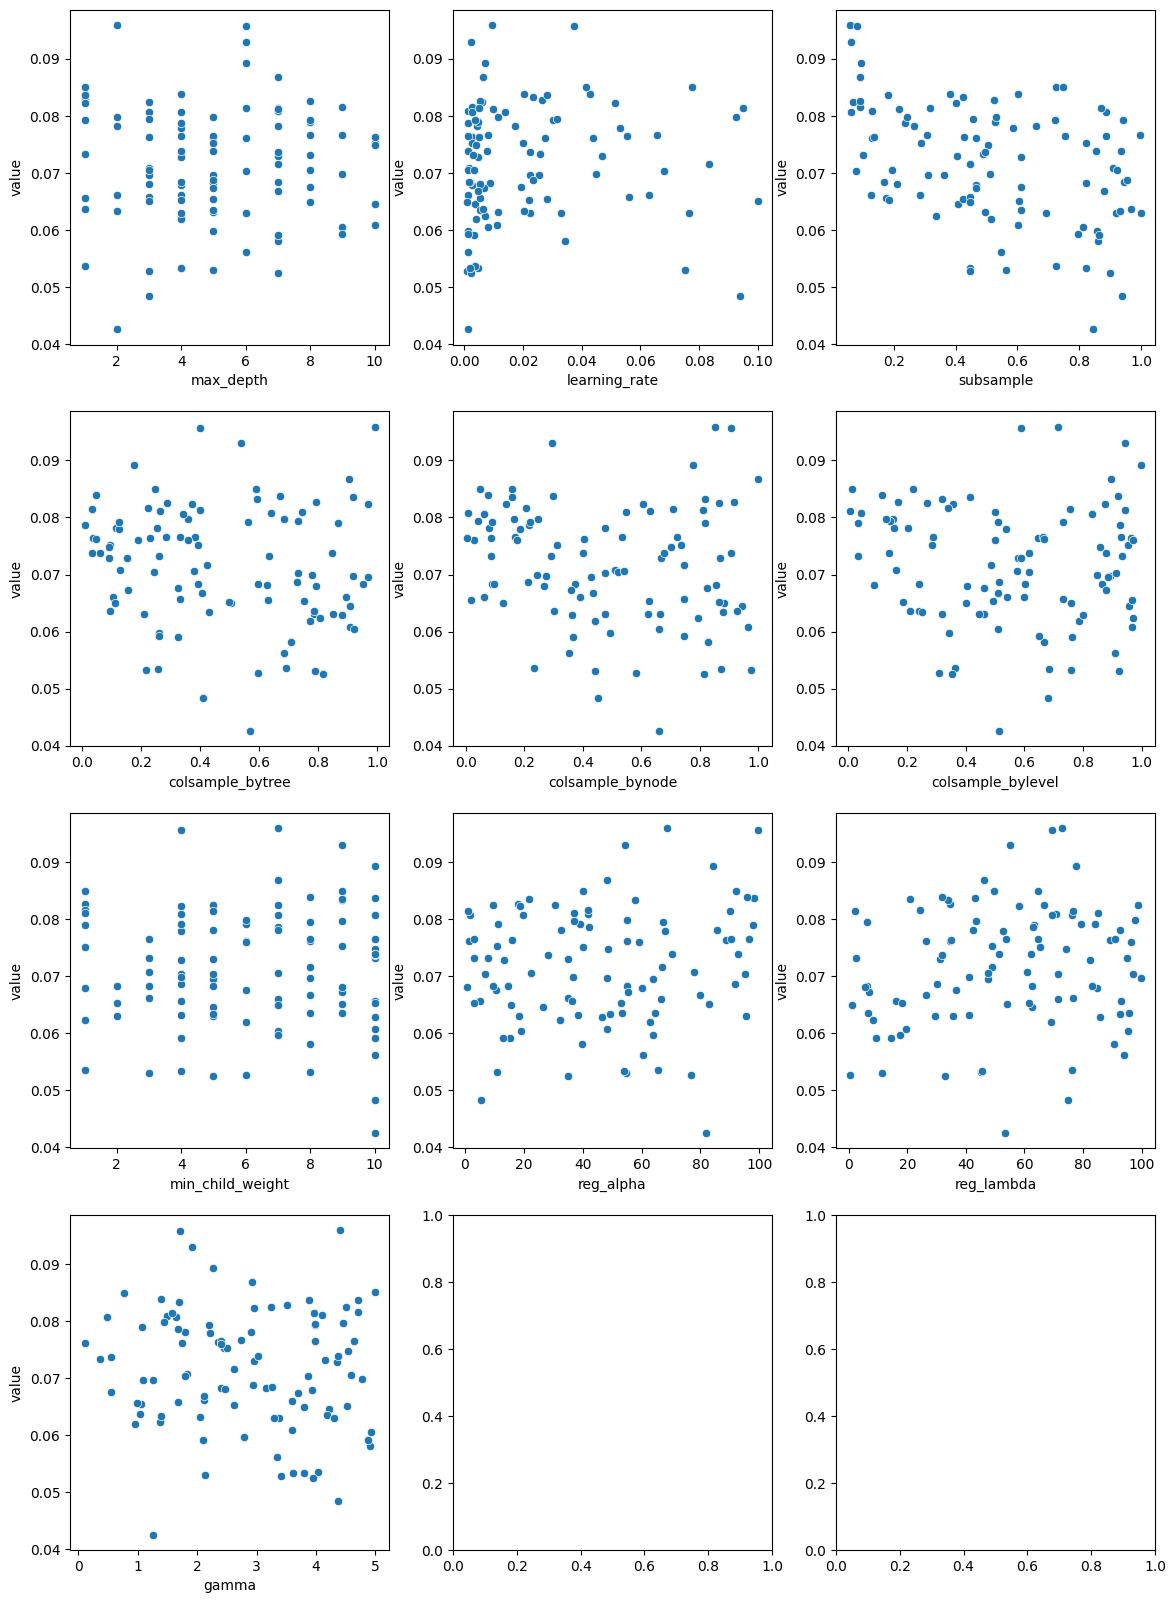

In [17]:
study_df_xgboost = get_study_df(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")   
params_value_viz(study_df_xgboost)

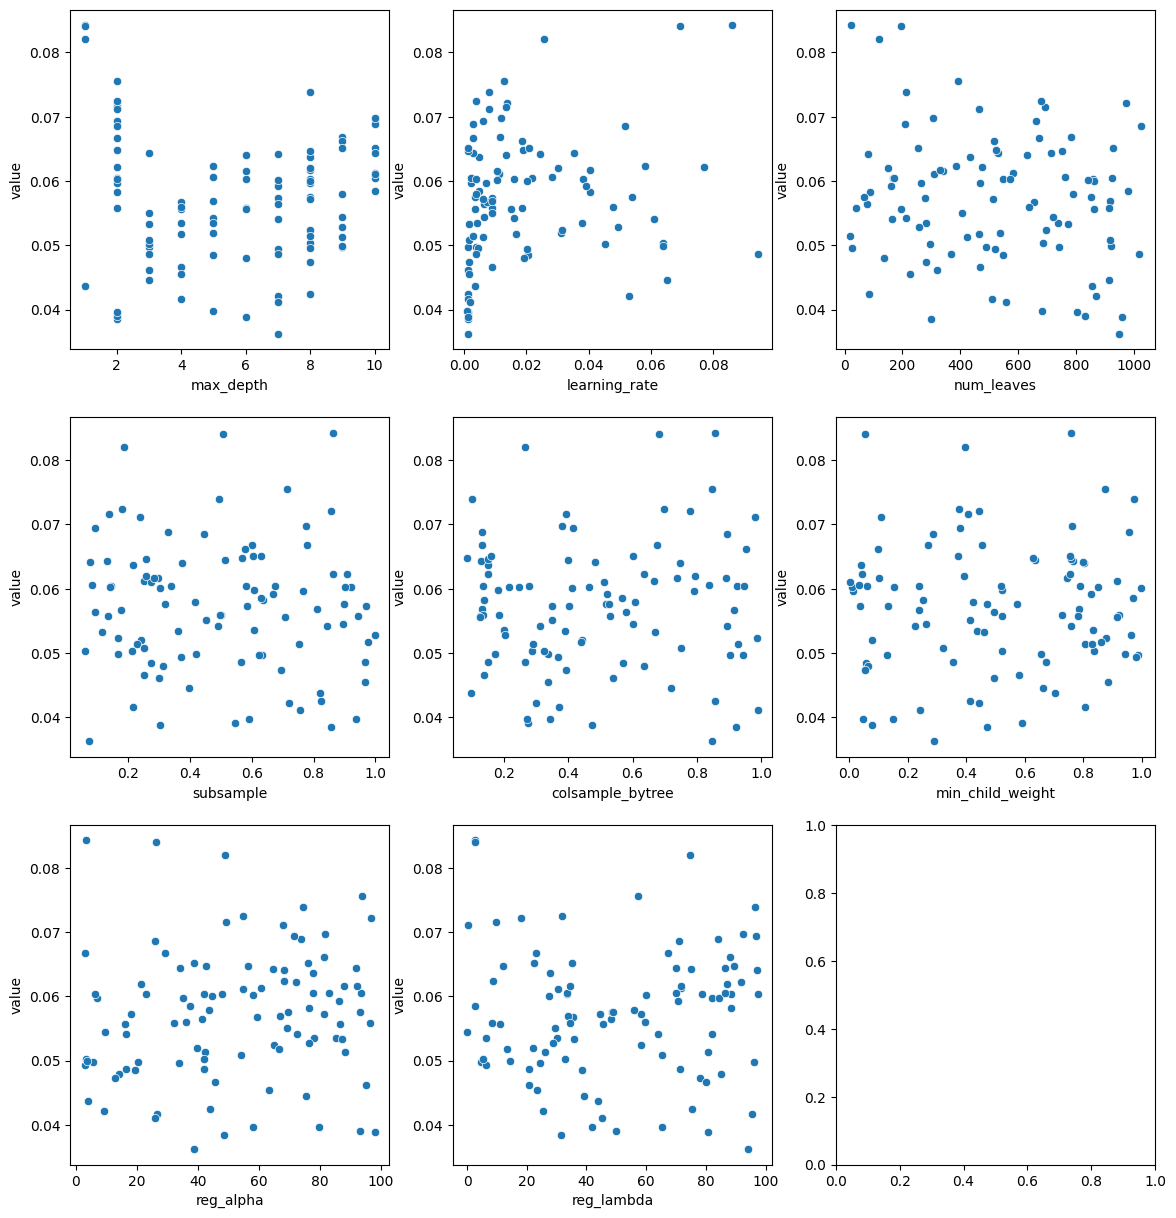

In [18]:
study_df_lightgbm = get_study_df(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
params_value_viz(study_df_lightgbm)

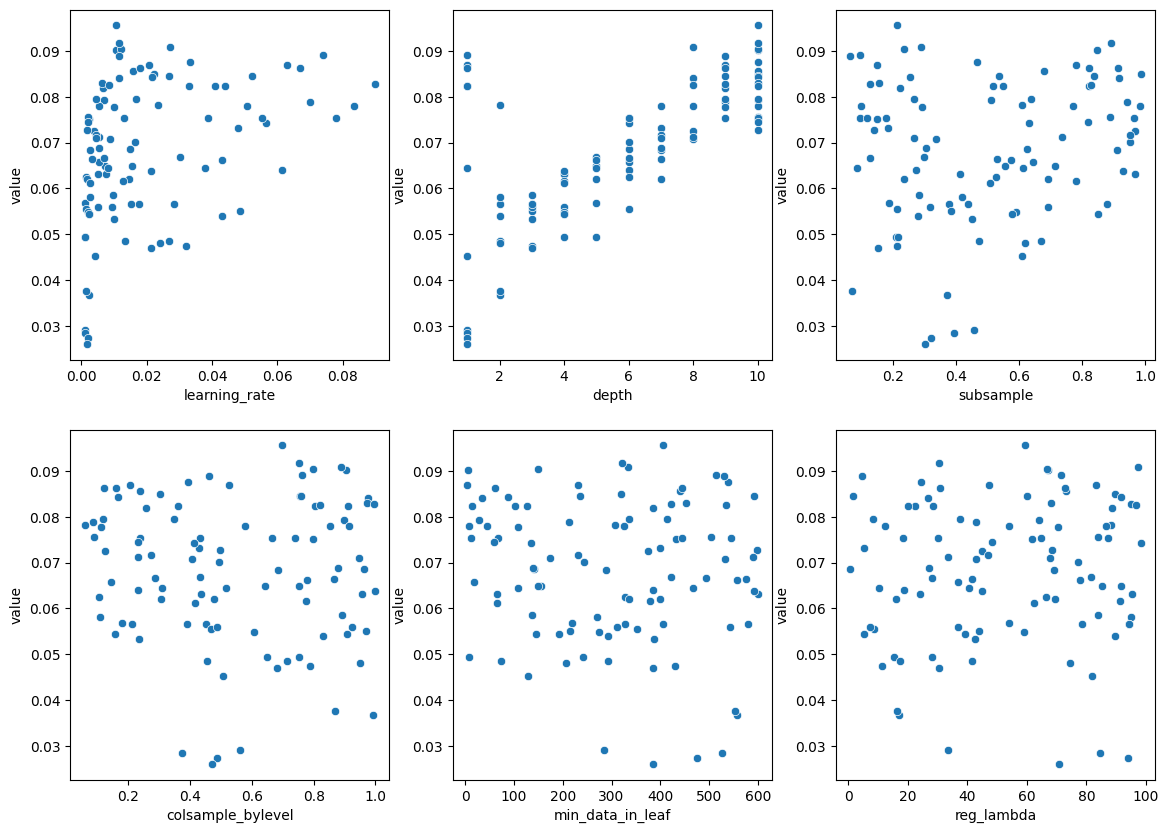

In [19]:
study_df_catboost = get_study_df(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
params_value_viz(study_df_catboost)

Analyze feature importance + CV performance

In [20]:
def get_best_params_from_file(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    return study.best_params

In [21]:
def get_shap_values(model, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, sample_size=10000):
    mean_abs_shap_all = np.zeros(X_train_arr[0].shape[1])
    for i in range(default_cv):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        X_test_sample = X_test.sample(sample_size, random_state = default_random_state)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        mean_abs_shap = np.mean(np.abs(shap_values), axis = 0)
        mean_abs_shap_all += mean_abs_shap
    mean_abs_shap_all /= default_cv
    return mean_abs_shap_all

0.09591519130021127


(array([99., 24.,  6.,  4.,  2.,  3.,  0.,  0.,  0.,  2.]),
 array([0.        , 0.00398413, 0.00796826, 0.01195239, 0.01593652,
        0.01992065, 0.02390478, 0.02788891, 0.03187304, 0.03585717,
        0.0398413 ]),
 <BarContainer object of 10 artists>)

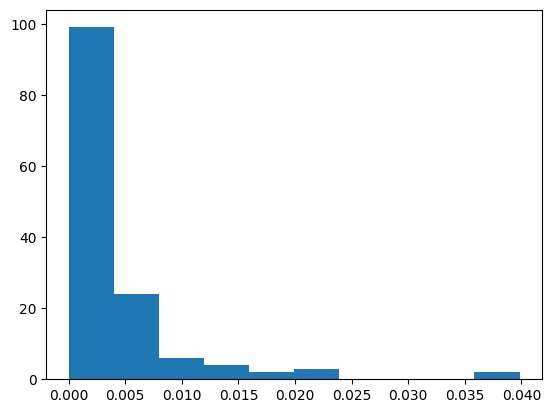

In [22]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, xgbr.predict(X_test)))
    features = xgbr.feature_names_in_.tolist()
    # features_i = xgbr.feature_importances_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

In [23]:
print([f for f in xgboost_feature_importances if xgboost_feature_importances[f] > 0.01])

['X28', 'X533', 'X862', 'X95', 'X856', 'X531', 'X863', 'X291', 'X284', 'X598', 'X379']


In [24]:
print([f for f in xgboost_feature_importances if xgboost_feature_importances[f] > 0.02])

['X28', 'X533', 'X862', 'X863', 'X598']


0.0842577434859161


(array([95., 19., 12.,  4.,  5.,  2.,  1.,  1.,  0.,  1.]),
 array([0.        , 0.0071666 , 0.01433319, 0.02149979, 0.02866639,
        0.03583298, 0.04299958, 0.05016618, 0.05733277, 0.06449937,
        0.07166597]),
 <BarContainer object of 10 artists>)

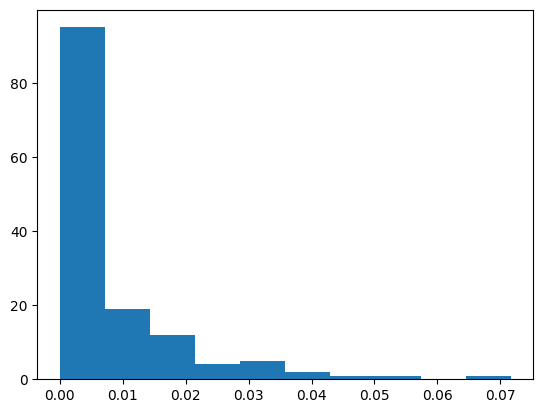

In [25]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, lgbr.predict(X_test)))
    features = lgbr.feature_names_in_.tolist()
    # features_i = lgbr.feature_importances_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
# seems to pick up time features not as good as past 4 hours features

In [26]:
print([f for f in lightgbm_feature_importances if lightgbm_feature_importances[f] >= 0.01])

['X198', 'X444', 'X466', 'X445', 'X137', 'X218', 'X28', 'X533', 'X226', 'X862', 'X758', 'X169', 'X89', 'X465', 'X754', 'X95', 'X861', 'X540', 'X856', 'X531', 'X297', 'X868', 'X863', 'X852', 'X272', 'X291', 'X284', 'X598', 'X379', 'X331', 'X298', 'X285', 'X292', 'X511', 'X279', 'X435', 'X296', 'X23']


In [27]:
print([f for f in lightgbm_feature_importances if lightgbm_feature_importances[f] >= 0.03])

['X466', 'X28', 'X533', 'X862', 'X465', 'X95', 'X863', 'X284', 'X598', 'X379']


0.09557266876294751


(array([70., 35., 12., 12.,  4.,  3.,  1.,  0.,  1.,  2.]),
 array([0.        , 0.00358803, 0.00717605, 0.01076408, 0.01435211,
        0.01794014, 0.02152816, 0.02511619, 0.02870422, 0.03229224,
        0.03588027]),
 <BarContainer object of 10 artists>)

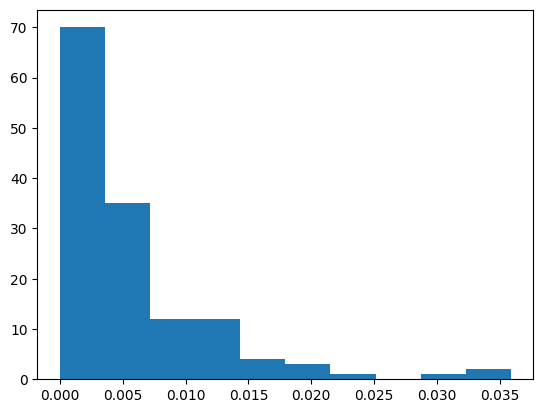

In [28]:
params = {
    "iterations": default_n_trees,
    "verbose": False,
    "random_seed": default_random_state
}
best_params_catboost = get_best_params_from_file(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

catboost_feature_importances = {}

cbr = CatBoostRegressor(**params)
cv_rmse = 0

for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    cbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, cbr.predict(X_test)))
    features = cbr.feature_names_
    # features_i = cbr.feature_importances_.tolist()
    features_i = get_shap_values(cbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        catboost_feature_importances[feat] = catboost_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(catboost_feature_importances.values())
# can pick up a combination of both past cod and tss, not good at picking up ph, temp

In [29]:
print([f for f in catboost_feature_importances if catboost_feature_importances[f] >= 0.02])

['X533', 'X862', 'X856', 'X863', 'X598']


Get top 20 important features in all of them

In [30]:
xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
catboost_feature_importances_df = pd.DataFrame(
    {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
)
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
feature_importances_df = feature_importances_df.merge(
    catboost_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("", "_catboost")
)
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])
feature_importances_df["importance"] = 1/3 * (feature_importances_df["importance_xgboost"] + feature_importances_df["importance_lightgbm"] + feature_importances_df["importance_catboost"])
feature_importances_df = feature_importances_df.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df[:50]

,var,importance_xgboost,importance_lightgbm,importance_catboost,importance
0,X862,0.022513,0.071666,0.035880,0.043353
1,X598,0.039660,0.049998,0.034715,0.041458
2,X863,0.039841,0.051960,0.031081,0.040960
3,X533,0.022325,0.033464,0.021743,0.025844
4,X379,0.018510,0.036288,0.019617,0.024805
5,X28,0.021420,0.033403,0.017405,0.024076
6,X284,0.016016,0.037156,0.012230,0.021801
7,X856,0.012954,0.026276,0.020407,0.019879
8,X95,0.012690,0.033516,0.011726,0.019310
9,X466,0.002077,0.035473,0.013296,0.016949


#### Second iteration: a more truncated version from the first collection

XGBoost

In [ ]:
xgboost_importance_threshold = 0.011
xgboost_best_features = [
    f for f in xgboost_feature_importances if xgboost_feature_importances[f] > xgboost_importance_threshold
] + ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"]
print(len(xgboost_best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, xgboost_best_features)

In [ ]:
best_xgboost_params_truncated = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_truncated_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_truncated_study"
) # much worse than using all features  

LightGBM

In [ ]:
lightgbm_importance_threshold = 20
lightgbm_best_features = [
    f for f in lightgbm_feature_importances if lightgbm_feature_importances[f] > lightgbm_importance_threshold
] + ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"]
print(len(lightgbm_best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, lightgbm_best_features)

In [ ]:
best_lightgbm_params_truncated = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_truncated_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_truncated_study"
)
# also much worse 

##### Third Iteration: a common truncated version using good features across all models + popular features

In [31]:
best_features = feature_importances_df.loc[:30, "var"].tolist() + \
                ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

XGBoost

In [32]:
best_xgboost_params_common_truncated = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study"
) 

[I 2025-06-13 01:03:33,215] A new study created in RDB with name: xgboost_2_1_101_1000_common_truncated_study


Conduct hyperparam opt for XGBoost


[I 2025-06-13 01:03:38,123] Trial 0 finished with value: 0.07249607608043375 and parameters: {'max_depth': 1, 'learning_rate': 0.028921861547484776, 'subsample': 0.552789675829587, 'colsample_bytree': 0.1756925099401796, 'colsample_bynode': 0.9621368330715344, 'colsample_bylevel': 0.9266424347353363, 'min_child_weight': 8, 'reg_alpha': 51.31318975035117, 'reg_lambda': 72.33626904238001, 'gamma': 3.872554521525788}. Best is trial 0 with value: 0.07249607608043375.
[I 2025-06-13 01:03:44,041] Trial 1 finished with value: 0.08247335429435991 and parameters: {'max_depth': 8, 'learning_rate': 0.023605582682991653, 'subsample': 0.06190998767881204, 'colsample_bytree': 0.7393193242878782, 'colsample_bynode': 0.8455325046986076, 'colsample_bylevel': 0.9432075389953997, 'min_child_weight': 5, 'reg_alpha': 22.43452011373247, 'reg_lambda': 98.72406928291689, 'gamma': 4.583618136441666}. Best is trial 1 with value: 0.08247335429435991.
[I 2025-06-13 01:03:45,521] Trial 2 finished with value: 0.090

Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.014635690696701339, 'subsample': 0.9881773374989135, 'colsample_bytree': 0.09538035518418087, 'colsample_bynode': 0.7649705143435778, 'colsample_bylevel': 0.2238996738966893, 'min_child_weight': 7, 'reg_alpha': 12.89047838297359, 'reg_lambda': 3.1078625582034447, 'gamma': 2.987064098354868}
Best Pearson score: 0.10591029644666657


LightGBM

In [33]:
best_lightgbm_params_common_truncated = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study"
)
# slightly worse

[I 2025-06-13 01:10:38,134] A new study created in RDB with name: lightgbm_2_1_101_1000_common_truncated_study


Conduct hyperparam opt for LightGBM


[I 2025-06-13 01:10:42,040] Trial 0 finished with value: 0.03598988737311667 and parameters: {'max_depth': 1, 'learning_rate': 0.0035715042818080574, 'num_leaves': 823, 'subsample': 0.4842717195847459, 'colsample_bytree': 0.7674159193014176, 'min_child_weight': 0.39694958860637275, 'reg_alpha': 3.6532605345260594, 'reg_lambda': 6.2702536207689175}. Best is trial 0 with value: 0.03598988737311667.
[I 2025-06-13 01:10:47,176] Trial 2 finished with value: 0.07228812175090801 and parameters: {'max_depth': 3, 'learning_rate': 0.049775657219340866, 'num_leaves': 596, 'subsample': 0.8571821187667014, 'colsample_bytree': 0.9330023560056286, 'min_child_weight': 0.2529527474675256, 'reg_alpha': 52.097910137507974, 'reg_lambda': 17.9410421559708}. Best is trial 2 with value: 0.07228812175090801.
[I 2025-06-13 01:10:52,166] Trial 3 finished with value: 0.07611367773313107 and parameters: {'max_depth': 3, 'learning_rate': 0.0018942790653073628, 'num_leaves': 76, 'subsample': 0.3000450110542516, 'co

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.00185358266153348, 'num_leaves': 120, 'subsample': 0.3280858553757597, 'colsample_bytree': 0.06757944120334153, 'min_child_weight': 0.82339768556501, 'reg_alpha': 7.276521407033187, 'reg_lambda': 10.815154726151954}
Best Pearson score: 0.09829786360393074


Catboost

In [34]:
best_catboost_params_common_truncated = optimize_catboost(
    f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study",
    f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study"
)


[I 2025-06-13 01:31:59,108] A new study created in RDB with name: catboost_2_1_101_1000_common_truncated_study


Conduct hyperparam opt for CatBoost


[I 2025-06-13 01:32:03,014] Trial 0 finished with value: 0.04918295758379622 and parameters: {'learning_rate': 0.006465269357998572, 'depth': 1, 'subsample': 0.5307379209850404, 'colsample_bylevel': 0.4321041908747754, 'min_data_in_leaf': 557, 'reg_lambda': 75.52466697106864}. Best is trial 0 with value: 0.04918295758379622.
[I 2025-06-13 01:32:09,577] Trial 2 finished with value: 0.08081377976904665 and parameters: {'learning_rate': 0.04058056972059364, 'depth': 4, 'subsample': 0.26597576283108, 'colsample_bylevel': 0.36750079889148324, 'min_data_in_leaf': 367, 'reg_lambda': 57.17662772952883}. Best is trial 2 with value: 0.08081377976904665.
[I 2025-06-13 01:32:30,165] Trial 1 finished with value: 0.08951695080954375 and parameters: {'learning_rate': 0.010204170590354186, 'depth': 10, 'subsample': 0.5147948152447112, 'colsample_bylevel': 0.6799819315867753, 'min_data_in_leaf': 33, 'reg_lambda': 47.18568954964486}. Best is trial 1 with value: 0.08951695080954375.
[I 2025-06-13 01:32:3

Best hyperparameters: {'learning_rate': 0.005044609819177839, 'depth': 10, 'subsample': 0.12007889794660107, 'colsample_bylevel': 0.8681681652065814, 'min_data_in_leaf': 36, 'reg_lambda': 36.734053593524216}
Best Pearson score: 0.09904505540517367
